<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Similarity-implementations" data-toc-modified-id="Similarity-implementations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Similarity implementations</a></span><ul class="toc-item"><li><span><a href="#Subject-Similarity-" data-toc-modified-id="Subject-Similarity--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Subject Similarity <a id="sub"></a></a></span></li><li><span><a href="#OpenKE-based-similarities---" data-toc-modified-id="OpenKE-based-similarities----1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OpenKE based similarities  <a id="OpenKE"> </a></a></span><ul class="toc-item"><li><span><a href="#OpenKE-Model-" data-toc-modified-id="OpenKE-Model--1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>OpenKE Model <a id="Model"></a></a></span></li><li><span><a href="#Cosine--" data-toc-modified-id="Cosine---1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Cosine  <a id="cos"></a></a></span><ul class="toc-item"><li><span><a href="#gen_all_cos()" data-toc-modified-id="gen_all_cos()-1.2.2.1"><span class="toc-item-num">1.2.2.1&nbsp;&nbsp;</span>gen_all_cos()</a></span></li><li><span><a href="#2nd-method" data-toc-modified-id="2nd-method-1.2.2.2"><span class="toc-item-num">1.2.2.2&nbsp;&nbsp;</span>2nd method</a></span></li></ul></li><li><span><a href="#DistMult-Avg--" data-toc-modified-id="DistMult-Avg---1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>DistMult Avg  <a id="avg"></a></a></span><ul class="toc-item"><li><span><a href="#gen_all_avg_DistMult_sim()" data-toc-modified-id="gen_all_avg_DistMult_sim()-1.2.3.1"><span class="toc-item-num">1.2.3.1&nbsp;&nbsp;</span>gen_all_avg_DistMult_sim()</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Append-module" data-toc-modified-id="Append-module-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Append module</a></span></li><li><span><a href="#AMIE-and-Evaluations" data-toc-modified-id="AMIE-and-Evaluations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>AMIE and Evaluations</a></span><ul class="toc-item"><li><span><a href="#Baseline-evaluation" data-toc-modified-id="Baseline-evaluation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Baseline evaluation</a></span></li><li><span><a href="#Enriched-KB-Evaluation" data-toc-modified-id="Enriched-KB-Evaluation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Enriched KB Evaluation</a></span></li></ul></li></ul></div>

# Similarity implementations

Important files:
- `./OpenKE/benchmarks/FB15K/train2id.txt` : \[int int int\]. Used by OpenKE based models (cosine, DistMult Avg) to find embeddings and Subject Similarity to find similarities.
- `./OpenKE/benchmarks/FB15K/entity2id.txt` : \[/mid int\].  
    - Used for translating similarity df from previous step to a df with this structure: \[ /mid /similar_to /mid \] .
    - Also used by Word2vec notebook.
- `./FB15K/mid2name.tsv` : \[ /mid word \]. Used by word2vec notebook.
- `./FB15K/train.txt` : \[/mid /mid /mid\]. Used by AMIE. Thus, enrichement must happen on this file.

-----

In [150]:
from itertools import combinations
import pandas as pd
import random

## Subject Similarity <a id="sub"></a>

The definition of similarity in this module is as follows:  

Let $e_i$ be an entity in the KB. Associated to $e_i$ there's a set $S_{e_i}$ defined by:


$$
S_{e_i} = \{ (r,e) | (e_i ,r,e) \in KB \}.
$$

It's the set of tuples $(r,e)$ such that $(e_i,r,e)$ is a triplet in the KB.


We say $e_i$ is similar to $e_j$ if $S_{e_i} \cap S_{e_j} \neq \emptyset$. Moreover, we define the similarity score between $e_i$ and $e_j$ by $sc(e_i,e_j) = | S_{e_i} \cap S_{e_j} |$.

In [2]:
# An implementation of the above is here:
# 
# Read every line in train2id and store the sets S_{e_i} in a list.
#

ent_total = 14951    # From the first line of ent2id.txt
file = "./OpenKE/benchmarks/FB15K/train2id.txt"
s = [ [] for _ in range(ent_total)] # A list of lists(sets). Will contain all sets S_{e_i}.

f = open(file,'r')
num_lines = f.readline()    # First line of train2id is the number of triplets
for i in range(int(num_lines)):
    l = f.readline()
    l = l.split()
    try:
        s[int(l[0])] += [ ( int(l[1]) , int(l[2]) ) ]
    except:
        print("something went wrong at triple" + str(i))
        raise
f.close()

In [4]:
#s

In [7]:
# ent_total = ent_total // 50     # for speed boost in tests

h = []
t = []
sc = []
for i,j in combinations(range(ent_total),2):
    score = len( set(s[i]) & set(s[j]) )
    if score:
        h.append(i)
        t.append(j)
        sc.append(score)


In [14]:
d = {'head':h , 'tail':t, 'score': sc}
df = pd.DataFrame(data=d)

In [29]:
df.loc[df['score'] > 2] # Nullius in verba

,head,tail,score
336,3,9513,3
439,4,129,3
442,4,253,4
450,4,1427,3
455,4,5775,3
...,...,...,...
385747,8072,8221,3
388707,8221,10385,3
391975,8390,9315,3
393494,8463,9730,3


With this data frame in hand, we can play so many different games, i.e. filtering out low scores, etc. But at the end these must be appended to the training file in mid format. So each integer `id` must be translated to `/mid` an then appended to train.txt in the form `/mid /similar_to /mid`.

For the appending operation we have defined another module that takes the filtered data frame as input. The filtered data frame must have only two columns named 'head' and 'tail'.

In [25]:
filt_df = df.loc[df['score'] > 2].copy()
filt_df.drop(columns='score',inplace=True)

In [30]:
filt_df # Nullius in verba again

,head,tail
336,3,9513
439,4,129
442,4,253
450,4,1427
455,4,5775
...,...,...
385747,8072,8221
388707,8221,10385
391975,8390,9315
393494,8463,9730


We write the function call for appending in the next cell in comments. So whenever needed you just need to uncomment and call create the train_enriched.txt in `./FB15K` folder. This will be later used by AMIE to mine rules.

In [ ]:
# filt_df #feed it to append module

----

## OpenKE based similarities  <a id="OpenKE"> </a>

We have two similarity routine based on DistMult in OpenKE. One is cos_sim and the other is avg_dist_mult. For these to run and generate the similarity data frame, first we need to run the OpenKE model which learns the embeddings. This is the first task, done in the section below.

### OpenKE Model <a id="Model"></a>

In [64]:
from OpenKE import models,config
import multiprocessing
import tensorflow as tf
import numpy as np
from itertools import combinations
import pandas as pd

In [47]:
con = config.Config()
con.set_in_path('./OpenKE/benchmarks/FB15K/')

In [48]:
con.set_test_link_prediction(True)
con.set_test_triple_classification(True)

con.set_work_threads(multiprocessing.cpu_count())

con.set_train_times(20)  # To set the data traversing rounds
con.set_nbatches(100)     # To split the training triples into several batches
con.set_alpha(0.1)        # To set the learning rate
con.set_dimension(100)    # To set the dimensions of the entities and relations at the same time
# con.set_margin(1)         # To set the margin for the loss function

con.set_bern(0)            # To set negative sampling algorithms, unif (bern = 0) or bern (bern = 1)
con.set_ent_neg_rate(1)   # For each positive triple, we construct rate negative triplentity
con.set_rel_neg_rate(0)

con.set_opt_method("Adagrad") 

con.set_export_files("./OpenKE/res/model.vec.tf", 0)  # To set the export file of model paramters, every few rounds
con.set_out_files("./OpenKE/res/embedding.vec.json") 

con.init()

#Set the knowledge embedding model
con.set_model(models.DistMult)

con.run()


#con.test()



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
(4831, 1)
Instructions for updating:
Use tf.cast instead.
Epoch: 0, loss: 107.19783335924149, time: 2.3903191089630127
Epoch: 1, loss: 79.77477234601974, time: 1.6785011291503906
Epoch: 2, loss: 58.410956144332886, time: 1.840184211730957
Epoch: 3, loss: 38.88628539443016, time: 1.8165099620819092
Epoch: 4, loss: 28.190808847546577, time: 1.6521151065826416
Epoch: 5, loss: 22.281101867556572, time: 1.6601297855377197
Epoch: 6, loss: 18.76488772034645, time: 1.6459269523620605
Epoch: 7, loss: 16.268416106700897, time: 1.6393451690673828
Epoch: 8, loss: 14.608845382928848, time: 1.6459901332855225
Epoch: 9, loss: 

In [49]:
embeddings = con.get_parameters('numpy')
ents = embeddings['ent_embeddings'] # Table of all entity vectors
#rels = embeddings['rel_embeddings']# Table of all relation vectors. Needed in avg_dist_mult.

In [50]:
ent_total = len(ents)

In [51]:
len(ents[0])

100

The next two sections("Cosine" and "DistMult Avg"), use the embeddings in `ents` and `rels`. In fact "Cosine" only uses `ents`.

-----

### Cosine  <a id="cos"></a>

Vinay has written a few functions that I copy here. We only use the first three.

In [60]:
def dot(x,y):
    return np.sum(x * y) 

# Vector Magnitude
def mag(x):
    return np.sqrt(np.sum(x * x))

# Cosine Similarity
def cosine_similar_to(h,t,ent_embeddings = ents):
    ent_h = ent_embeddings[h]
    ent_t = ent_embeddings[t]
    cos_sim = np.absolute(dot(ent_h,ent_t)) / (mag(ent_h) * mag(ent_t))
    return(cos_sim)

def gen_cos_sim_links(iterations = 100000, threshold = 0.8, embeddings = ents): 
    
    h_list = []; t_list = []; acc_list = []
    for _ in range(iterations):
        h = random.randint(1, 14540)  # this is wrong. It's excluding 0, the first entity.
        t = random.randint(1, 14540)  # and also it does'nt see that (i,j) = (j,i).
        acc = cosine_similar_to(h,t,embeddings)
        if acc > threshold:
            h_list.append(h)
            t_list.append(t)       
    
    d = {'head': h_list, 'tail': t_list}
    return pd.DataFrame(data = d)



In [61]:
def rand_comb(n): 
    """ Return a generator(iterator) object that simulates random n choose 2.
    
    In other words, randomly select an entry from upper or lower half
    of a symmetric matrix and return it.
    You can also check the histogram to see the choice are not biased 
    toward upper/lower half.
    """
    mem_set = set()
    c = 0
    while c < n*(n-1)/2:
        while True:
            i = random.randint(0,n-1)
            j = random.randint(0,n-1)
            while j==i:
                j = random.randint(0,n-1)
            if set([i,j]) not in mem_set:
                break     
        mem_set.add(frozenset([i,j]))
        c+=1
        yield (i,j)

Basically I'm providing two routines to find cos_similar tuples. One is the function `gen_all_cos()` in the next cell. And the other method is in the section after.

Since generating all the similar tuples is a costly process, we use generators to allow partial generation. The default generator starts from the first entry and checks for similar entries in an orderly manner, which is ok if we want to let it generate all. But if you want to generate the data frame partialy then you might want to randomize the process.

`gen_all_cos()` has all the options and you can stop it whenever you want and get partial results. But the 2nd method also works and is good for testing.

#### gen_all_cos()

In [62]:
def gen_all_cos(rand=False):
    """Return a data frame containing head, tail, and score for similar tuples.
    
    Rand -- (default=False): chose tuples randomly.
    Also prints the percentage of checked tuples. If interupted (KeyboardInterrupt)
    it still returns the (incomplete) data frame.
    """
    # Pros:
    # 1) you can stop it anytime and get partial results
    # 2) It attempts to exhaust all combinations in a random way. So the histogram of 
    # heads/tails is pretty uniform whenever you stop.
    # Cons:
    # 1) A little bit slower than the next method.
    # 2) probbaly even slower when randomizing and near the end of the process.
    tot = ent_total*(ent_total-1)/2
    c=0
    threshold = .8
    try:
        head = []
        tail = []
        sc = []
        if rand:
            for i,j in rand_comb(ent_total):
                if not(c%100000):
                    print(100*c/tot) # print progress % every 100k iteration
                c+=1
                score = cosine_similar_to(i,j)
                if score > threshold:
                    head.append(i)
                    tail.append(j)
                    sc.append(score)
        else:
            for i,j in combinations(range(ent_total),2):
                if not(c%100000):
                    print(100*c/tot) # print progress % every 100k iteration
                c+=1
                score = cosine_similar_to(i,j)
                if score > threshold:
                    head.append(i)
                    tail.append(j)
                    sc.append(score)
    except KeyboardInterrupt:
        print('KeyboardInterrupt at ' + f'{100*c/tot:.3f} %')
        
        if len(head) > len(tail):
            print("head popped!")
            head.pop()
        elif len(head) < len(tail):
            print("tail popped!")
            tail.pop()
        
        if len(sc) < len(head):
            print("pop pop!")
            head.pop()
            tail.pop()
        
        if not(len(sc) == len(head) == len(tail)):
            print("""len s,h,t still don't match :( Ain't 
                  possible but if happened, then last row contains NaNs """)
            h = pd.DataFrame({'head':head})
            t = pd.DataFrame({'tail':head})
            s = pd.DataFrame({'sc':head})
            new = pd.concat([h, t,s], axis=1)
            return new
        
        print("head: " + str(len(head)) + " tail: " + str(len(tail)) + " sc: " + str(len(sc)) )
    
    d = {'head':head , 'tail':tail, 'score': sc}
    df = pd.DataFrame(data=d)
    return df 

In [65]:
df_cos_sim = gen_all_cos()

0.0
0.08947847248615265
0.1789569449723053
0.26843541745845795
0.3579138899446106
KeyboardInterrupt at 0.420 %
head: 44 tail: 44 sc: 44


In [66]:
filt_cos_df = df_cos_sim.loc[df_cos_sim['score'] > .85].copy() # more filtering if necc.
filt_cos_df.drop(columns='score',inplace=True)
filt_cos_df # feed it to append module

,head,tail
0,9,10
1,9,17
2,9,174
3,10,17
4,10,174
7,17,174


#### 2nd method

With the help of the generators defined in the next cell, you can manually generate finitely many similar tuples.

In [161]:
# The next two function are for manual iteration through similar tuples.
def gen_iter(threshold = .8): 
    """ Return an iterator that generates similar tuples.
    
    next two cells show the usage.
    """
    for i,j in combinations(range(ent_total),2):
        score = cosine_similar_to(i,j)
        if score > threshold:
            yield (i,j,score)
            
def gen_iter_rand(threshold=.8):
    """ Return an iterator that generates similar tuples in a random order.
    
    next two cells show the usage.
    """
    for p,q in rand_comb(ent_total):
            score = cosine_similar_to(p,q)
            if score > threshold:
                yield (p,q,score)

The next two cell allow you to do what you want by just setting the flags at the begining.

In [162]:
#######################
# Keep this cell separate.
# Run this only once to get the generator object, 
# then run the next cell as many times as you want.
#
# To reset the process, come back here and start over.
#

RAND = False

df_cos_sim = pd.DataFrame(columns=['head', 'tail', 'cos_score'])
if RAND:
    sims = gen_iter_rand()
else:    
    sims = gen_iter()
#######################

In [163]:
# This cell appends finitely many (`iterations`) new rows to the data frame
# each time you run it.
# If you spend long enough time running it then at some point you will get 
# StopIteration exception which means you have exhausted all the combinations. Good job!
# 
# Set iterations as desired but remember 14951 choose 2 = 111,758,725 is the upper bound
# for number of rows of df_cos_sim.
#

iterations = 9
for _ in range(iterations):
    (h,t,sc) = next(sims)
    df_cos_sim = df_cos_sim.append({'head': h, 'tail': t,'cos_score': sc}, ignore_index=True)
    
df_cos_sim    
    

,head,tail,cos_score
0,1.0,6321.0,0.832283
1,1.0,8571.0,0.811631
2,9.0,10.0,0.895150
3,9.0,17.0,0.897638
4,9.0,174.0,0.899374
5,10.0,17.0,0.894460
6,10.0,174.0,0.905054
7,12.0,11043.0,0.819847
8,17.0,174.0,0.866708


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1aa1ba2c50>,
      dtype=object)

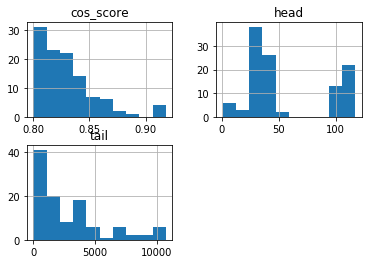

In [91]:
df_cos_sim.hist()

In [102]:
# if you wanna do more filtering then go ahead and then drop score column and
# pass it to append module.
df_cos_sim = df_cos_sim.loc[df_cos_sim['cos_score'] > .85].copy()
df_cos_sim.drop(columns='cos_score',inplace=True)
df_cos_sim

,head,tail
0,9.0,10.0
1,9.0,17.0
2,9.0,174.0
3,10.0,17.0
4,10.0,174.0
6,17.0,174.0
12,28.0,3807.0
14,28.0,4192.0
19,28.0,9739.0


In [ ]:
# pass to append module

### DistMult Avg  <a id="avg"></a>

In this method, for each pair $(e_i,e_j)$ of entities we calculate the DistMult loss $l_k$ of 
$(e_i, r_k ,e_j)$ for all $k$. Since the $l_k$ is actully loss value, we take those that are negative and average them to get the score value $Sc(e_i,e_j)$. Then this score value is used to decide wheather $e_i$ and $e_j$ are similar or not.

In [167]:
rels = embeddings['rel_embeddings'] # Get the relation embeddings from OpenKE
rel_total = len(rels)

Similar to the previous section, this process could also be written in various ways. Here I have provided the main function `gen_all_avg_DistMult_sim()` which similar to `gen_all_cos()` generates all the similarities and can be interrupted without loss. 

Of course, you can also copy the 2nd method above here if interested.

#### gen_all_avg_DistMult_sim()

In [193]:
def DistMult_avg_sim(h,t):
    """ Return the avg DistMult similarity score of a tuple.
    
    It's a negative number. Since it actually is capturing loss.
    """
    test_h = np.array([h] * rel_total)
    test_r = np.array(range(rel_total))
    test_t = np.array([t] * rel_total)
    res = con.test_step(test_h, test_t, test_r).reshape(-1) # list of all loss values
    N = res[res < 0].size
    if N==0:
        return 1
    score = np.sum(res[res < 0])/N
    return score

In [266]:
def gen_all_DistMult_sim(rand=False):
    """Return a data frame containing head, tail, and score for similar tuples.
    
    Rand -- (default=False): chose tuples randomly.
    Also prints the percentage of checked tuples. If interupted (KeyboardInterrupt)
    it still returns the (incomplete) data frame.
    """
    # Pros:
    # 1) You can stop it anytime and get partial results
    # 2) rand=True => it exhaust all combinations in a random way. So the histogram of 
    # heads/tails is pretty uniform whenever you stop.
    # Cons:
    # 1) A little bit slow because of percentage, ... . Comment them out if you like.
    # 2) Slow when rand=True and near the end of the process.
    tot = ent_total*(ent_total-1)/2
    c=0
    threshold = -3
    try:
        head = []
        tail = []
        sc = []
        if rand:
            for i,j in rand_comb(ent_total):
                if not(c%1000000):
                    print(100*c/tot) # print progress % every 100k iteration
                c+=1
                score = DistMult_avg_sim(i,j)
                if score < threshold: # Score value here is loss, so less is better.
                                      # To decide on this threshold, remove the cond and look
                                      # at the output histogram. I'm putting -3 for now.
                    head.append(i)
                    tail.append(j)
                    sc.append(score)
        else:
            for i,j in combinations(range(ent_total),2):
                if not(c%1000000):
                    print(100*c/tot) # print progress % every 100k iteration
                c+=1
                score = DistMult_avg_sim(i,j)
                if score < threshold: # Score value here is loss, so less is better.
                                      # To decide on this threshold, remove the cond and look
                                      # at the output histogram. I'm putting -3 for now.
                    head.append(i)
                    tail.append(j)
                    sc.append(score)
    except KeyboardInterrupt:
        print('KeyboardInterrupt at ' + f'{100*c/tot:.3f} %')
        if len(head) > len(tail):
            print("head popped!")
            head.pop()
        elif len(head) < len(tail):
            print("tail popped!")
            tail.pop()
        if len(sc) < len(head):
            print("pop pop!")
            head.pop()
            tail.pop()
        if not(len(sc) == len(head) == len(tail)):
            print("""len s,h,t still don't match :( Ain't 
                  possible but if happened, then last row contains NaNs """)
            h = pd.DataFrame({'head':head})
            t = pd.DataFrame({'tail':head})
            s = pd.DataFrame({'sc':head})
            new = pd.concat([h, t,s], axis=1)
            return new
        print("head: " + str(len(head)) + " tail: " + str(len(tail)) + " sc: " + str(len(sc)) )
    d = {'head':head , 'tail':tail, 'score': sc}
    df = pd.DataFrame(data=d)
    return df 

In [267]:
dist_df = gen_all_DistMult_sim()

0.0
KeyboardInterrupt at 0.005 %
head: 48 tail: 48 sc: 48


In [268]:
dist_df

,head,tail,score
0,0,96,-3.006979
1,0,104,-3.154193
2,0,144,-3.177240
3,0,223,-3.513156
4,0,245,-3.221455
5,0,395,-3.065530
6,0,396,-3.372768
7,0,422,-3.022748
8,0,569,-3.546024
9,0,645,-3.500739


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3f8264a8>,
      dtype=object)

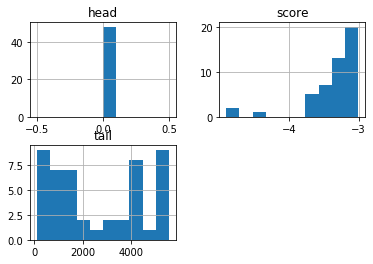

In [269]:
dist_df.hist()

---

In [272]:
filt_dist_df = dist_df.loc[dist_df['score'] < -4].copy()
filt_dist_df.drop(columns='score',inplace=True)
filt_dist_df # feed it to append module

,head,tail
19,0,1443
22,0,1660
46,0,5395


# Append module 

Here we provide the append function. The result from each one of the previous sections, is a data frame with two columns, _head_ and _tail_. That data frame must be appende to `train.txt` in the format of 
```
head_mid /similar_to tail_mid
```
The following function is written to do exactly that.

In [21]:
import os

In [44]:
def append_train(input_df,new_name):
    """ Appends the input data frame to a copy of train.txt.
    
    input_df: --pd.DataFrame: has two columns 'head', and 'tail' containing
    the integer ids for heads and tails of similar tuples.
    new_name: --str: name of the new file will be train_{new_name}.txt 
    """
    dest = './FB15K/train_app_'+ new_name + '.txt'
    while os.path.isfile(dest):
        new_name = input("File already exists. Give another name: ")
        dest = './FB15K/train_app_'+ new_name + '.txt'
    
    heads = list(input_df['head']) 
    tails = list(input_df['tail']) 

    # Translate int ids to /mid
    ents = pd.read_csv("./OpenKE/benchmarks/FB15K/entity2id.txt",sep = '\t',header=None, skiprows=[0],usecols=[0]) # first row is lineTot
    heads_mid = list(ents.iloc[heads,0]) 
    rels_mid = ['/similar_to']*len(heads)
    tails_mid = list(ents.iloc[tails,0]) 

    d = {'head': heads_mid , 'relation': rels_mid, 'tail':tails_mid}
    df = pd.DataFrame(data=d)

    from shutil import copyfile
    copyfile('./FB15K/train.txt', dest)
    df.to_csv(dest, mode='a', header=False,index=False, sep='\t')
    return dest

In [67]:
append_train(filt_cos_df,'cos')

File already exists. Give another name: cos_enr


'./FB15K/train_app_cos_enr.txt'

# AMIE and Evaluations 

Running AMIE on each training file produces two outputs. Firsts the rules `./rules/{KB_name}_rules.txt` and then the evaluation of the rules `./evaluation/{KB_name}_rules_eval.txt`. Then calling the function `eval_frame("./evaluation/{KB_name}_rules_eval.txt")` will measure the accuracy of rules by Hits@10.

After enriching the KB with similarity links, we run the above procedure twice. Once on `train.txt` to get __Baseline evaluations__ and again on `train_enriched_{name}.txt`. Then compare the outputs from `eval_frame()`.

In [68]:
def eval_frame(file, test_len):
    
    # Open file
    f = open(file)
    
    # Hits counter
    hits = 0
    
    # Loop though all facts in KB
    for x in range(test_len):

        # Read line
        fact = f.readline()
        fact = fact.split(' ')
        if fact != ['']:
            # Get target head and tail
            head_target = fact[0]
            tail_target = fact[2][:-1]


            # Get head predictions
            headpreds = f.readline()
            headpreds = headpreds.split(' ')
            headpreds = headpreds[1].split('\t')
            headpreds.pop()

            # Get tail predictions
            tailpreds = f.readline()
            tailpreds = tailpreds.split(' ')
            tailpreds = tailpreds[1].split('\t')
            tailpreds.pop()


            if (head_target in headpreds) and (tail_target in tailpreds):
                if (len(headpreds) < 10) and (len(tailpreds) < 10):
                    hits+=1
        else:
            print('miss')
                
    return hits/(test_len)

## Baseline evaluation 

Just type in the right files in the next cell and continue.

In [69]:
train_add = "./FB15K/train_app_cos_enr.txt"
test_add = "FB15K/test.txt"
valid_add = "FB15K/valid.txt"

rules_add = "rules/baseline_rules.txt"
eval_add = "evaluation/baseline_rules_eval.txt"

In [73]:
# The text of the commands for running AMIE

AMIE_plus = ("java -XX:-UseGCOverheadLimit -Xmx4g -jar AMIE/amie_plus.jar "
"-minhc 0.0 -mins 0 -minis 0 " 
f"{train_add} > {rules_add}")

Apply_AMIE_RULES = (f'java -jar AMIE/ApplyAMIERules.jar {rules_add}' 
                    f' {train_add} {test_add} {valid_add}'
                    f' {eval_add}')

The next cell will generate the rules and save them in `rules_add`.

In [71]:
os.system(AMIE_plus)

0

Clean the output from previous cell (i.e. `rules_add`) before running applying AMIE rules. The header and footer of the file `rules_add` must be deleted. It should only contain rules.

In [75]:
os.system(Apply_AMIE_RULES)

0

In [76]:
# Get the lenght of the test file. It is fed to eval_frame()
import subprocess
test_len = subprocess.run(['wc', '-l', test_add], stdout=subprocess.PIPE).stdout.decode('utf-8')
test_len = int(test_len.split()[0])
test_len

59071

In [42]:
print(eval_add)
print('Hits@10: ' + str(eval_frame(eval_add, test_len)))

Hits@10: 3.3857561239863894e-05


---

## Enriched KB Evaluation 

Basically repeat everything from Baseline Evaluation for the enriched training file.

In [72]:
train_add = "./FB15K/train_app_cos_enr.txt" # From append module
test_add = "FB15K/test.txt"
valid_add = "FB15K/valid.txt"

rules_add = "rules/Enriched_rules.txt" # modify this name if you like
eval_add = "evaluation/Enriched_rules_eval.txt" # same here


# The texts of the commands for running AMIE
AMIE_plus = ("java -XX:-UseGCOverheadLimit -Xmx4g -jar AMIE/amie_plus.jar "
"-minhc 0.0 -mins 0 -minis 0 " 
f"{train_add} > {rules_add}")

Apply_AMIE_RULES = (f'java -jar AMIE/ApplyAMIERules.jar {rules_add}' 
                    f' {train_add} {test_add} {valid_add}'
                    f' {eval_add}')

os.system(AMIE_plus)

trim `{}_rules.txt` again

In [ ]:
os.system(Apply_AMIE_RULES) # if output is 256 then you forgot to trim

In [78]:
print(eval_add)
print('Hits@10: ' + str(eval_frame(eval_add, test_len)))

evaluation/Enriched_rules_eval.txt
Hits@10: 0.18892519171844052
